# Olympics data with SQL and pandas- height weight and age
> What is the height, weight and age of athletes in the Olympics

- toc: true 
- badges: true
- categories: [SQL, Athletes, Pandas, python, Olympics]

![](ghtop_images/header2.png)

## Background

I did some initial plots on the changes in the characteristics of athletes given in the data, `height`, `weight` and `age`, of athletes attending the Olympics by year (see below). 

From these plots I was really intrigued as to what may be the cause of these changes. 

Mainly what was happening between 1960 and 1980 were there seemed to be changes in each of the parameters?

My initial thought was this could be related to some combination of 
- a switch from amateurs to professionals 
- the Cold War between USA and USSR
- an after effect of WWII


![](ghtop_images/weight_Year_all.png)

![](ghtop_images/height_Year_all.png)

![](ghtop_images/age_Year_all.png)




### Olympic Background

Throughout much of the Olympic's history there has been tension around professionals and amateur athletes. The games were intended for amateur athletes, and those who played sport professionally were banned or even had their medals stripped. 

The reasoning behind amateurism was based on how sport was seen by the aristrocracy and greatly influenced Pierre de Coubertin, who is thought of as the father of the Olympic games:

    "There was also a prevailing concept of fairness, in which practising or training was considered tantamount to cheating.[2] Those who practised a sport professionally were considered to have an unfair advantage over those who practised it merely as a hobby.[2]"

The Soviet Union, who competed from 1952-1988, entered teams of athletes who were all nominally students, soldiers, or working in a profession, but all of whom were in reality paid by the state to train on a full-time basis.[3] The situation greatly disadvantaged American and Western European athletes, and was a major factor in the decline of American medal hauls in the 1970s and 1980s. However, workarounds in Western countries also allowed individuals to focus full-time on sport while passing the amateur rules.[4]



This abuse of amateur rules by the Eastern Bloc nations prompted the IOC to shift away from pure amateurism.The rules were steadily relaxed from 1972, amounting only to technicalities and lip service, until being completely abandoned in the 1990s 


1. [Wikipedia Olympic Games And Amateurism](https://en.wikipedia.org/wiki/Olympic_Games#Amateurism_and_professionalism)
1. [Eassom 1994, pp. 120–123](https://en.wikipedia.org/wiki/Olympic_Games#CITEREFEassom1994)
1. ["The Role of Sports in The Soviet Union – Guided History". blogs.bu.edu.](http://blogs.bu.edu/guidedhistory/russia-and-its-empires/tyler-benson/)
1. [Degrees of Difficulty: How Women's Gymnastics Rose to Prominence and Fell from Grace", by Georgia Cervin](https://www.jstor.org/stable/10.5406/j.ctv1ns7nt1)



## Load data and libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandasql import sqldf
import copy
import numpy as np
import scipy.stats

In [2]:
df_F_S =pd.read_csv('athlete_F_S')
df_F_W=pd.read_csv('athlete_F_W')
df_M_S=pd.read_csv('athlete_M_S')
df_M_W=pd.read_csv('athlete_M_W')

df_all_athletes= pd.read_csv('all_athletes')
df_country= pd.read_csv('country')
df_event= pd.read_csv('event')
# df_games= pd.read_csv('games')
# df_population= pd.read_csv('population')

# df_country = df_country.groupby('NOC').max()
# df_country.head(10)

## What are the best Weight, Height, Age?

Obviously this will depend on event. But if we average across events what are
- the best of values of these? 
- and how do these change with time?

To get this figure the methodology is fairly simple, in the SQL query:
- We take the average of weight, height, age across years and medal type
- Because we want a simple binary answer (medal or not) we create a variable called `medal` which is 1 if they got a medal and 0 otherwise
- We then group on this and take an average
- The two function below are just so we can plot for `avg_weight`, `avg_height` and `avg_age` without repeating the same steps

*here Male summer athletes are used but the result for female summer athletes show the same trend*

In [3]:
medalQ=sqldf('\
    SELECT                                 \
        Year,                              \
        medal,                             \
        AVG(avg_weight)    AS avg_weight,  \
        AVG(avg_height)    AS avg_height,  \
        AVG(avg_age)       AS avg_age      \
    FROM                                   \
         (SELECT                           \
         Year,                             \
         MAX(Medal_Gold,Medal_Silver,Medal_Bronze)\
                           AS medal,       \
         avg(Weight)       AS avg_weight,  \
         AVG(Height)       AS avg_height,  \
         AVG(age)          AS avg_age      \
         from df_M_S                       \
         group by                          \
             Year,                         \
             Medal_Gold,Medal_Silver,Medal_Bronze           \
         order by Year asc) A              \
     GROUP BY Year, medal;',locals())  
medalQ.head()

,Year,medal,avg_weight,avg_height,avg_age
0,1896,0,70.444444,169.916667,23.896552
1,1896,1,71.551282,175.217949,23.211671
2,1900,0,76.971429,175.054545,29.428571
3,1900,1,72.711355,178.202932,28.454139
4,1904,0,71.742424,175.131579,26.752080


In [4]:
def modname(string):
    string=''.join([string[0].upper(),string[1:].lower()])
    string=string.replace('_',' ')
    return string
    
def plotMedal(plotchoi,medalQ):
    plt.subplots(figsize=(8,5))
    plt.plot(medalQ[medalQ.medal==1].Year,medalQ[medalQ.medal==1][plotchoi],'g*-')

    plt.plot(medalQ[medalQ.medal==0].Year,medalQ[medalQ.medal==0][plotchoi],'rv--')

    plt.legend(['Medal','No medal'])
    plt.grid(True)
    plt.xlabel('Year')
    plt.ylabel(modname(plotchoi))

(18.0, 40.0)

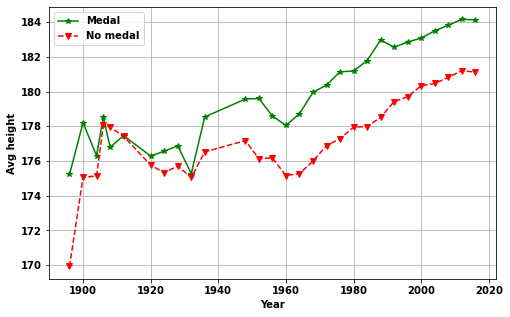

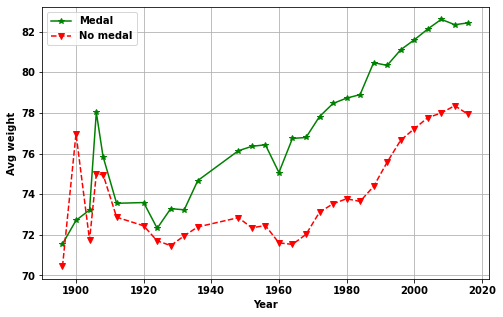

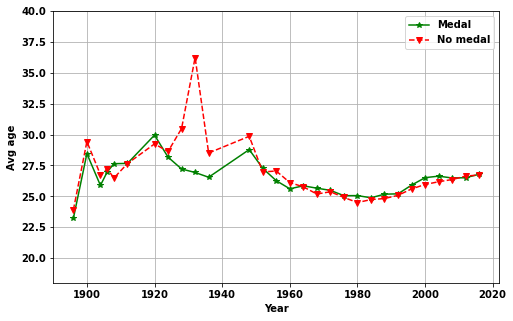

In [5]:
plotchoi='avg_height'
plotMedal(plotchoi,medalQ)

plotchoi='avg_weight'
plotMedal(plotchoi,medalQ)

plotchoi='avg_age'
plotMedal(plotchoi,medalQ)
plt.ylim([18,40])

### Answer: What is the best weight, height and age?

- Age, height and weight of athletes change with year
- After the initial years (> ~1930)
    - Athletes who get more medals have greater height and weight 
    - Whereas, the age is indistinguishable 

## The change in athletes based on weight, height and age

Here the methodology used to produce the figures in the background section is presented.

The method is fairly simple, we just use each athlete table and then GROUP BY year and take the averages

In [6]:
df_F=\
     sqldf('SELECT                              \
              Year,                             \
               avg(Height) AS avg_height,       \
               avg(Weight) AS avg_weight,       \
               avg(Age)    AS avg_age           \
            FROM                                \
                df_F_S AS d                     \
            GROUP BY                            \
               Year                             \
            ORDER BY                            \
                Year asc;',locals())
df_M=\
     sqldf('SELECT                              \
              Year,                             \
               avg(Height) AS avg_height,       \
               avg(Weight) AS avg_weight,       \
               avg(Age)    AS avg_age           \
            FROM                                \
                df_M_S AS d                     \
            GROUP BY                            \
               Year                             \
            ORDER BY                            \
                Year asc;',locals())
               
df_Fw=\
     sqldf('SELECT                              \
              Year,                             \
               avg(Height) AS avg_height,       \
               avg(Weight) AS avg_weight,       \
               avg(Age)    AS avg_age           \
            FROM                                \
                df_F_W AS d                     \
            GROUP BY                            \
               Year                             \
            ORDER BY                            \
                Year asc;',locals())
df_Mw=\
     sqldf('SELECT                              \
              Year,                             \
               avg(Height) AS avg_height,       \
               avg(Weight) AS avg_weight,       \
               avg(Age)    AS avg_age           \
            FROM                                \
                df_M_W AS d                     \
            GROUP BY                            \
               Year                             \
            ORDER BY                            \
                Year asc;',locals())
               
df_F.head()                    

,Year,avg_height,avg_weight,avg_age
0,1900,NaN,NaN,29.791667
1,1904,NaN,NaN,50.230769
2,1906,NaN,NaN,23.500000
3,1908,NaN,NaN,33.897436
4,1912,NaN,NaN,22.379310


In [7]:
def yrplot(df_F,df_M,df_Fw,df_Mw,whatplot= 'avg_weight'): 
    cola=['r>','b<','mo','cs']

    plt.subplots(figsize=(6,4))
    plt.plot(df_F.Year,df_F[whatplot],cola[0],markersize=10)

    plt.plot(df_M.Year,df_M[whatplot],cola[1],markersize=10)

    plt.plot(df_Fw.Year,df_Fw[whatplot],cola[2])
    plt.plot(df_Mw.Year,df_Mw[whatplot],cola[3])

    def doPlot(df_F,avgNo,whatplot,col,lw):
        bb = df_F.Year.rolling(avgNo).mean()
        cc = df_F[whatplot]
        cc = cc.rolling(avgNo).mean()
        plt.plot(bb,cc,col,linewidth=lw)

    doPlot(df_F,3,whatplot,'r-',4)
    doPlot(df_M,3,whatplot,'b-',4)

    doPlot(df_Fw,3,whatplot,'m--',2)
    doPlot(df_Mw,3,whatplot,'c--',2)

    plt.legend(['Female Summer','Male Summer','Female Winter','Male Winter'])
    plt.ylabel(modname(whatplot),fontsize=14)
    plt.xlabel('Year',fontsize=14)
    plt.xlim([1890, 2020])
    plt.grid(True)

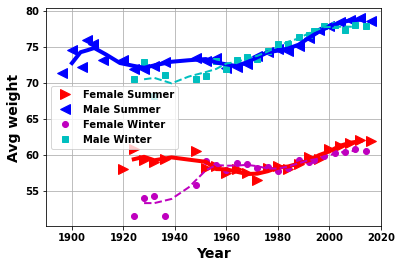

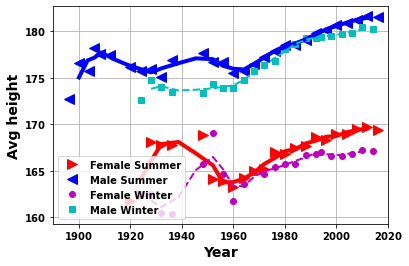

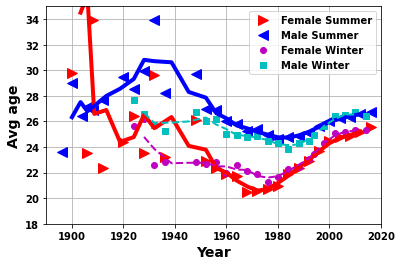

In [8]:
yrplot(df_F,df_M,df_Fw,df_Mw,whatplot= 'avg_weight')
yrplot(df_F,df_M,df_Fw,df_Mw,whatplot= 'avg_height')
yrplot(df_F,df_M,df_Fw,df_Mw,whatplot= 'avg_age')
plt.ylim([18,35]);

### Are the changes due to changes in athletes or changes in the Olympics? 



- Join athlete table `df_M_S` with event table `df_event`
    - Use this to get a list of events and the year they occur
- Group this table
    - To get which event meet criteria of a minimum date, maximum date and having occured so many times
    
`(select `

`      Event_id`

......

` AND max(year)>1990) usea`

- Group the table of events with the athlete table `df_M_S`
- Take the average over the events and year
- Take this average just over year
    - This stops changes due to changes in number of athletes in a particular event
    
There are 15-20 events included in the results below. Although, a relatively low figure this still represents a lot of athletes. Furthermore, when we split these events into 2 the same trends we find in all the data are seen in the two splits. The absolute values can differ but the min./max. values seem to fairly consistent. But obviously more exploration would be beneficial if this is led by theories or experts in the areas. Without this we could spend forever looking for trends.

In [9]:
# --find events that have occured more than a set amount within a range of dates
# -- i.e. events that can focus on to see results of changes with time

def do_same_event(df_M_S,df_F_S,df_event,athlete_df_name='df_M_S',counta='17',yr_start='1900',yr_end='1990'):
    tempa= sqldf('                               \
    SELECT                                   \
        Year,                                \
        avg(wgt)            AS avg_weight,   \
        avg(hgt)            AS avg_height,   \
        avg(aga)            AS avg_age       \
    FROM                                     \
        (SELECT                              \
        Year,                                \
        AVG(weight)         AS wgt,          \
        AVG(height)         AS hgt,          \
        AVG(age)            AS aga           \
        FROM                                 \
        (SELECT                              \
          Event_id                           \
        FROM                                 \
            (SELECT                          \
            E.Event_id,                      \
            Year,                            \
            count(*)        AS counta        \
            FROM                             \
                {0}         AS A             \
            LEFT JOIN                        \
                df_event    AS E             \
            ON                               \
                E.event_id = A.event_id      \
            GROUP BY                         \
                E.Event_id,                  \
                Year                         \
            ORDER BY year asc) AA            \
        GROUP BY AA.Event_id                 \
        HAVING COUNT(*) >{1}                 \
        AND MIN(year)<{2}                    \
        AND MAX(year)>{3}                    \
        ORDER BY event_id asc                \
        LIMIT 80) usea                       \
        LEFT JOIN                            \
            {0}              AS a            \
        ON                                   \
            usea.event_id = a.event_id       \
        GROUP BY                             \
            year,                            \
            usea.event_id                    \
        ORDER BY year asc) two               \
        GROUP BY year;'.format(athlete_df_name,counta,yr_start,yr_end),locals())
    return tempa

In [10]:
tempaM = do_same_event(df_M_S,df_F_S,df_event,'df_M_S')
tempaF = do_same_event(df_M_S,df_F_S,df_event,'df_F_S',counta='12',yr_start='1945',yr_end='1990')

tempaF.head()

,Year,avg_weight,avg_height,avg_age
0,1900,NaN,NaN,25.250000
1,1906,NaN,NaN,23.500000
2,1908,NaN,NaN,31.200000
3,1912,NaN,NaN,21.759259
4,1920,NaN,160.145833,21.737132


In [11]:
def modname(string):
    string=''.join([string[0].upper(),string[1:].lower()])
    string=string.replace('_',' ')
    return string

def yrplot1(df_F,df_M,whatplot): 
    cola=['r>','b<','mo','cs']

    fig,ax=plt.subplots(figsize=(8,5))
    ax.plot(df_F.Year,df_F[whatplot],cola[0],markersize=10)
    ax2=ax.twinx()
    ax2.plot(df_M.Year,df_M[whatplot],cola[1],markersize=10)

#     plt.plot(df_Fw.Year,df_Fw[whatplot],cola[2])
#     plt.plot(df_Mw.Year,df_Mw[whatplot],cola[3])


    def doPlot(df_F,avgNo,whatplot,col,lw,xx):
        bb = df_F.Year.rolling(avgNo).mean()
        cc = df_F[whatplot]
        cc = cc.rolling(avgNo).mean()
        xx.plot(bb,cc,col,linewidth=lw)

    doPlot(df_F,3,whatplot,'r-',4,ax)
    doPlot(df_M,3,whatplot,'b-',4,ax2)

#     doPlot(df_Fw,3,whatplot,'m--',2)
#     doPlot(df_Mw,3,whatplot,'c--',2)

    fig.legend(['Female Summer','-','Male Summer','-'],loc='upper center')#,'Female Winter','Male Winter'])
    ax.set_ylabel('Female ' + modname(whatplot),fontsize=14)
    ax2.set_ylabel('Male ' + modname(whatplot),fontsize=14)
    ax.set_xlabel('Year',fontsize=14)
    plt.xlim([1890, 2020])
    ax2.grid(True)
    

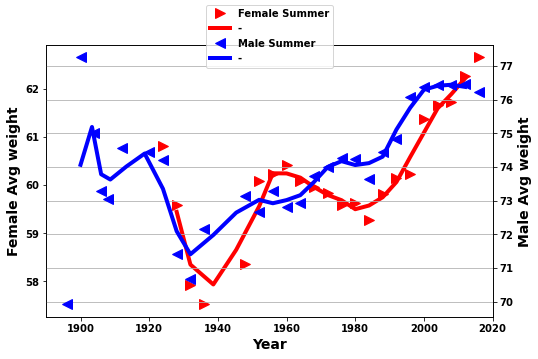

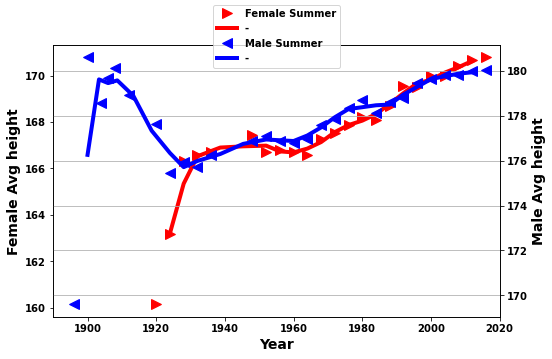

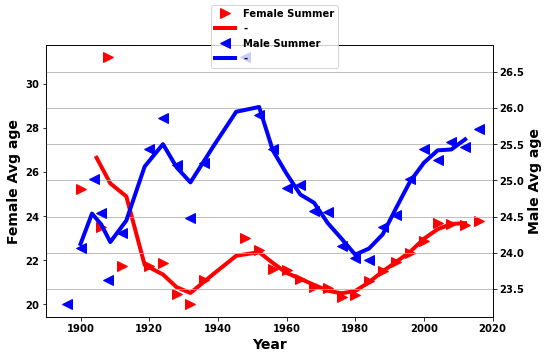

In [12]:
yrplot1(tempaF,tempaM,whatplot= 'avg_weight')
yrplot1(tempaF,tempaM,whatplot= 'avg_height')
yrplot1(tempaF,tempaM,whatplot= 'avg_age')
# no limit

## The Cold War

In [13]:
def yrplot(df__,whatplot= 'avg_weight'): 
    
    countries=['EST', 'EUN' ,'ROW', 'USA' ,'WES']
    
#     df__.NOCSMALL.unique()
#     countries=np.sort(countries)
    print(countries)
    cola=['>','o','+','*','<']
    colur=[[1,0.6,.6],[1,0,0],[.5,.5,.5],[0,0,1],[.6,.6,1]]
#     ['EST' 'EUN' 'ROW' 'USA' 'WES']
#     'EST','USA','WES','ROW','EUN'

    fig,ax1=plt.subplots(figsize=(8,5))
    
    for i,country in enumerate(countries):
        if country!='ROW':
            ax1.plot(df__[df__.NOCSMALL==country].Year,\
                 df__[df__.NOCSMALL==country][whatplot],\
                 marker=cola[i],linestyle='None',color=colur[i]\
                 ,markersize=10)


    def doPlot(df_F,avgNo,whatplot,country,col,lw,ax1):
        bb = df_F[df__.NOCSMALL==country].Year.rolling(avgNo).mean()
        cc = df_F[df__.NOCSMALL==country][whatplot]
        cc = cc.rolling(avgNo).mean()
        ax1.plot(bb,cc,linewidth=lw,color=col)
        return ax1

    for i,country in enumerate(countries):
        if country!='ROW':
            ax1=doPlot(df__,avgNo=3,whatplot=whatplot,country=country,col=colur[i],lw=3,ax1=ax1)
    
    lega = ['East Europe','Russia','USA','West Europe']
    plt.legend(lega)
    plt.grid(True)
    plt.ylabel(modname(whatplot))
    
    return ax1


def get_df_USA_USSR(df_M_S,df_F_S,nameDF):
    USA_USSR=sqldf(\
           'SELECT                            \
              Year,                           \
              NOCSMALL,                       \
              AVG(avg_height)  AS avg_height, \
              AVG(avg_weight)  AS avg_weight, \
              AVG(avg_age)     AS avg_age,    \
              SUM(number_of_athletes) AS number_of_athletes         \
           FROM                                    \
               (SELECT                             \
                   Year,                           \
                   AVG(avg_height)  AS avg_height, \
                   AVG(avg_weight)  AS avg_weight, \
                   AVG(avg_age)     AS avg_age,    \
                   SUM(num_ath) AS number_of_athletes,        \
                   CASE                                \
                       WHEN NOC IN ("FRA","ESP","ITA","POR","GBR","IRL","NED","BEL","DEN","SUI") THEN "WES"\
                       WHEN NOC IN ("POL","ROU","UKR","LAT","BUL","HUN","LTU","LAT","BLR","ALB","SVK","AUT","EST","BIH","BOH") THEN "EST"\
                       WHEN NOC="USA" THEN "USA"       \
                       WHEN NOC="EUN" THEN "EUN"       \
                       ELSE "ROW"\
                   END AS NOCSMALL,                     \
                   NOC\
               FROM                               \
                  (SELECT                         \
                  Year,                           \
                  NOC,                            \
                  avg(Height) AS avg_height,      \
                  avg(Weight) AS avg_weight,      \
                  avg(Age)    AS avg_age,         \
                  count(*)    AS num_ath          \
                  FROM                            \
                    {} AS d                       \
                  GROUP BY                        \
                    Year,NOC                      \
                  ORDER BY                        \
                    Year asc) A                   \
              GROUP BY                            \
                Year,NOC) B                       \
           GROUP BY Year, NOCSMALL ;'.format(nameDF),locals())
    return USA_USSR


def do_USA_USSR(df_M_S,df_F_S,men_women,whatplot):
    if men_women=='men':
        nameDF='df_M_S'
    elif men_women=='women':
        nameDF='df_F_S'
    
        
    USA_USSR_F = get_df_USA_USSR(df_M_S,df_F_S,nameDF)
    ax1=yrplot(USA_USSR_F,whatplot)
    
    return ax1
    
    

['EST', 'EUN', 'ROW', 'USA', 'WES']


(65.0, 90.0)

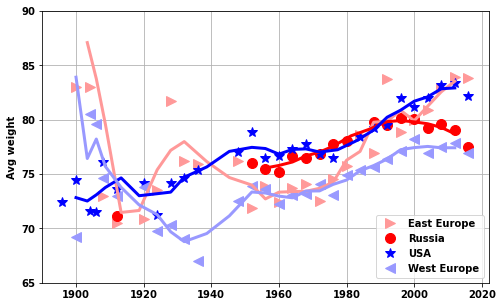

In [14]:
do_USA_USSR(df_M_S,df_F_S,'men','avg_weight')
plt.ylim([65, 90])

['EST', 'EUN', 'ROW', 'USA', 'WES']


(50.0, 70.0)

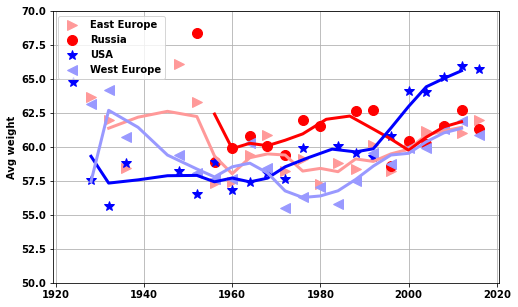

In [15]:
do_USA_USSR(df_M_S,df_F_S,'women','avg_weight')
plt.ylim([50, 70])

['EST', 'EUN', 'ROW', 'USA', 'WES']


<AxesSubplot:ylabel='Avg height'>

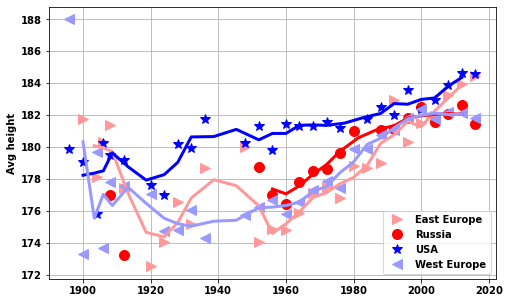

In [16]:
do_USA_USSR(df_M_S,df_F_S,'men','avg_height')


['EST', 'EUN', 'ROW', 'USA', 'WES']


<AxesSubplot:ylabel='Avg height'>

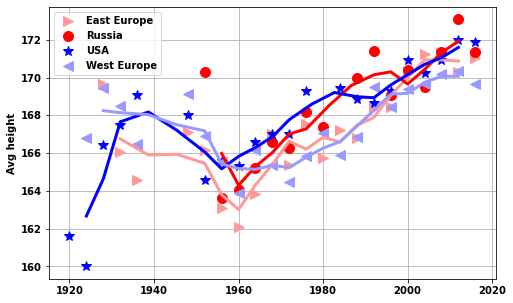

In [17]:
do_USA_USSR(df_M_S,df_F_S,'women','avg_height')
# plt.ylim([65, 90])

['EST', 'EUN', 'ROW', 'USA', 'WES']


<AxesSubplot:ylabel='Avg age'>

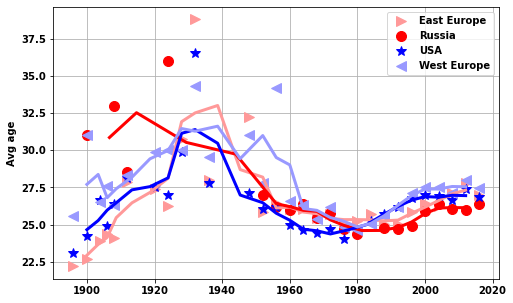

In [18]:
do_USA_USSR(df_M_S,df_F_S,'men','avg_age')
# plt.ylim([65, 90])

['EST', 'EUN', 'ROW', 'USA', 'WES']


(18.0, 35.0)

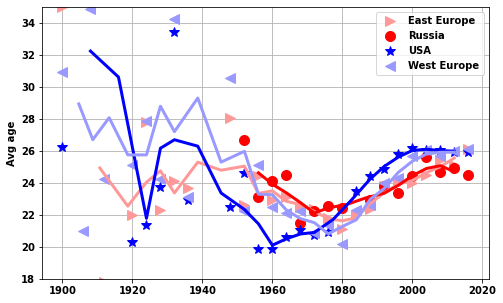

In [19]:
do_USA_USSR(df_M_S,df_F_S,'women','avg_age')
plt.ylim([18, 35])

In [20]:
def number_of_athletes_USA_USSR(df_F_S,df_M_S):
    testa2=sqldf('\
        SELECT                                 \
        Year,                              \
        NOCSMALL,                          \
        count(*) AS number_of_athletes,     \
        "F" AS Sex                          \
    FROM                                   \
         (SELECT                           \
         athlete_ID,                        \
         Year,                             \
         CASE                                \
            WHEN NOC IN ("FRA","ESP","ITA","POR","GBR","IRL","NED","BEL","DEN","SUI") THEN "WES"\
            WHEN NOC IN ("POL","ROU","UKR","LAT","BUL","HUN","LTU","LAT","BLR","ALB","SVK","AUT","EST","BIH","BOH") THEN "EST"\
            WHEN NOC="USA" THEN "USA"       \
            WHEN NOC="EUN" THEN "EUN"       \
            ELSE "ROW"\
            END AS NOCSMALL                \
         from df_F_S                       \
         group by athlete_ID,Year               \
         order by Year asc) A              \
     GROUP BY Year, NOCSMALL               \
     UNION ALL                                 \
     SELECT                                \
        Year,                              \
        NOCSMALL,                          \
        count(*) AS number_of_athletes,     \
        "M" AS Sex                          \
    FROM                                   \
         (SELECT                           \
         athlete_ID,                        \
         Year,                             \
         CASE                                \
            WHEN NOC IN ("FRA","ESP","ITA","POR","GBR","IRL","NED","BEL","DEN","SUI") THEN "WES"\
            WHEN NOC IN ("POL","ROU","UKR","LAT","BUL","HUN","LTU","LAT","BLR","ALB","SVK","AUT","EST","BIH","BOH") THEN "EST"\
            WHEN NOC="USA" THEN "USA"       \
            WHEN NOC="EUN" THEN "EUN"       \
            ELSE "ROW"\
            END AS NOCSMALL                \
         from df_M_S                       \
         group by athlete_ID,Year          \
         order by Year asc) A              \
     GROUP BY Year, NOCSMALL;',locals()  )
    return testa2

def number_of_medals_USA_USSR(df_F_S,df_M_S):
    testa2=sqldf('\
        SELECT                                 \
            COUNT(*) AS number_of_medals,\
            Year, Sex, NOCSMALL\
        FROM \
        (SELECT NOCSMALL,Year,Sex,COUNT(*) AS counta\
        FROM                                   \
         (SELECT                           \
         athlete_ID,                        \
         event_ID,                          \
         "F"   AS Sex,                      \
         Medal_Gold,Medal_Silver,Medal_Bronze,\
         Year,                             \
         CASE                                \
            WHEN NOC IN ("FRA","ESP","ITA","POR","GBR","IRL","NED","BEL","DEN","SUI") THEN "WES"\
            WHEN NOC IN ("POL","ROU","UKR","LAT","BUL","HUN","LTU","LAT","BLR","ALB","SVK","AUT","EST","BIH","BOH") THEN "EST"\
            WHEN NOC="USA" THEN "USA"       \
            WHEN NOC="EUN" THEN "EUN"       \
            ELSE "ROW"\
            END AS NOCSMALL                \
         from df_F_S                       \
         WHERE Medal_Gold=1 OR Medal_Silver=1 OR Medal_Bronze=1\
         UNION ALL                                 \
         SELECT                           \
         athlete_ID,                        \
         event_ID,                          \
         "M" AS Sex,                       \
         Medal_Gold,Medal_Silver,Medal_Bronze,\
         Year,                             \
         CASE                                \
            WHEN NOC IN ("FRA","ESP","ITA","POR","GBR","IRL","NED","BEL","DEN","SUI") THEN "WES"\
            WHEN NOC IN ("POL","ROU","UKR","LAT","BUL","HUN","LTU","LAT","BLR","ALB","SVK","AUT","EST","BIH","BOH") THEN "EST"\
            WHEN NOC="USA" THEN "USA"       \
            WHEN NOC="EUN" THEN "EUN"       \
            ELSE "ROW"\
            END AS NOCSMALL                \
         from df_M_S                       \
         WHERE Medal_Gold=1 OR Medal_Silver=1 OR Medal_Bronze=1\
         order by Year asc) A\
     GROUP BY \
         Year, NOCSMALL,event_id,Medal_Gold,Medal_Silver,Medal_Bronze)  AS B\
 GROUP BY Year, NOCSMALL, Sex\
                 ;',locals()  )                                       
    return testa2


USA_USSR_medals=number_of_medals_USA_USSR(df_F_S,df_M_S)
USA_USSR_athletes=number_of_athletes_USA_USSR(df_F_S,df_M_S)


In [21]:
USA_USSR_medals.head()

,number_of_medals,Year,Sex,NOCSMALL
0,11,1896,M,EST
1,61,1896,M,ROW
2,19,1896,M,USA
3,29,1896,M,WES
4,2,1900,F,EST


['EST', 'EUN', 'ROW', 'USA', 'WES']


<AxesSubplot:ylabel='Number of medals'>

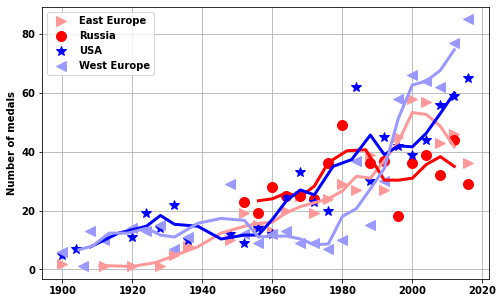

In [22]:
yrplot(USA_USSR_medals[USA_USSR_medals.Sex=='F'],whatplot= 'number_of_medals')

['EST', 'EUN', 'ROW', 'USA', 'WES']


<AxesSubplot:ylabel='Number of medals'>

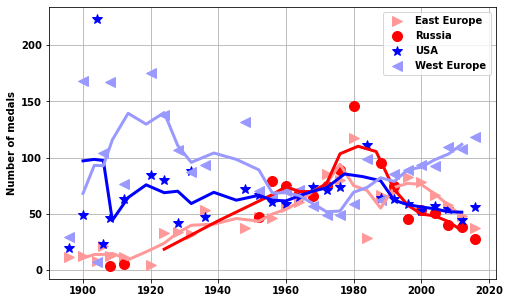

In [23]:
yrplot(USA_USSR_medals[USA_USSR_medals.Sex=='M'],whatplot= 'number_of_medals')

['EST', 'EUN', 'ROW', 'USA', 'WES']


<AxesSubplot:ylabel='Number of athletes'>

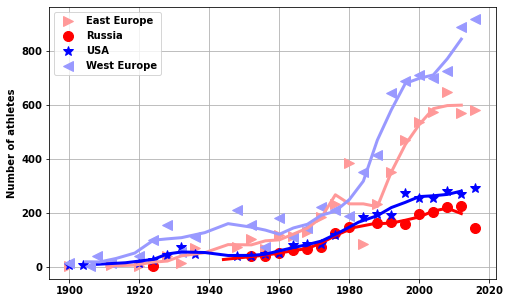

In [24]:
yrplot(USA_USSR_athletes[USA_USSR_athletes.Sex=='F'],whatplot= 'number_of_athletes')

['EST', 'EUN', 'ROW', 'USA', 'WES']


<AxesSubplot:ylabel='Number of athletes'>

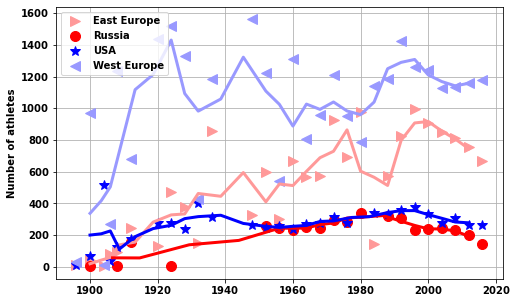

In [25]:
yrplot(USA_USSR_athletes[USA_USSR_athletes.Sex=='M'],whatplot= 'number_of_athletes')